In [1]:
import loss
import importlib
importlib.reload(loss)

import os, sys
from data import TestDatasetFromFolder, ValDatasetFromFolder, TrainDatasetFromFolder
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from model import *
from loss import *
from ssim import *
from torch.utils.tensorboard import SummaryWriter
from math import log10
from PIL import Image
import math

In [2]:
UPSCALE_FACTOR = 4

In [3]:
image_dir = '../../data/'

voc_dir = image_dir + '/VOC2012/X' + str(UPSCALE_FACTOR)
set5_test_dir = image_dir + '/Set5/X' + str(UPSCALE_FACTOR)
set14_test_dir = image_dir + '/Set14/X' + str(UPSCALE_FACTOR)
print(voc_dir)
# ------------------- 数据集 --------------------------------------------
train_set = TrainDatasetFromFolder(voc_dir + '/train', upscale_factor=UPSCALE_FACTOR)
val_set = ValDatasetFromFolder(voc_dir + '/val', upscale_factor=UPSCALE_FACTOR)
set5_test_set = TestDatasetFromFolder(set5_test_dir, upscale_factor=UPSCALE_FACTOR)
set14_test_set = TestDatasetFromFolder(set14_test_dir, upscale_factor=UPSCALE_FACTOR)


train_loader = DataLoader(dataset=train_set, batch_size=64, 
                          shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=64, 
                        shuffle=False, num_workers=4, pin_memory=True)
set5_test_loader = DataLoader(dataset=set5_test_set, batch_size=1, 
                              shuffle=False, num_workers=4, pin_memory=True)
set14_test_loader = DataLoader(dataset=set14_test_set, batch_size=1, 
                               shuffle=False, num_workers=4, pin_memory=True)

print(f'train_loader len: {len(train_loader)}')
print(f'val_loader len: {len(val_loader)}')
print(f'set5_test_loader len: {len(set5_test_loader)}')
print(f'set14_test_loader len: {len(set14_test_loader)}')

../data//VOC2012/X4
train_loader len: 3952
val_loader len: 100
set5_test_loader len: 5
set14_test_loader len: 14


In [4]:
# helper function to show an image
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
        
    nping = img.numpy()
    if one_channel:
        plt.imshow(nping, cmap='Greys')
    else:
        plt.imshow(np.transpose(nping, (1, 2, 0)))

LR\baby.png


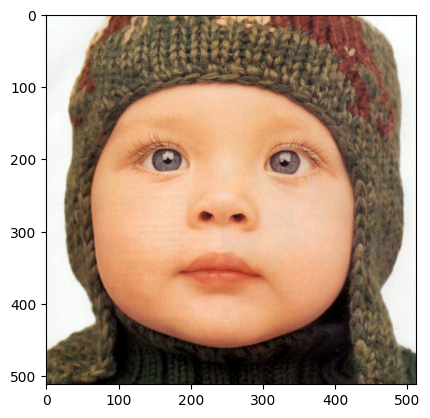

In [5]:
name, lr, hr_re, hr = set5_test_set[0]

print(name)
matplotlib_imshow(hr)

# model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator_loss = GeneratorLoss()
bce_loss_fn = nn.BCELoss()
mse_loss_fn = nn.MSELoss()

device

device(type='cuda')

In [7]:
netG = Generator(UPSCALE_FACTOR).to(device)
print(f'generator parameters: {sum(param.numel() for param in netG.parameters())}')
netD = Discriminator().to(device)
print(f'discriminator prameters: {sum(param.numel() for param in netD.parameters())}')

generator parameters: 734219
discriminator prameters: 5215425


In [8]:
optimizerG = optim.Adam(netG.parameters(), lr=1e-4)
optimizerD = optim.Adam(netD.parameters(), lr=1e-4)

real_label = 1
fake_label = 0

In [9]:
from tqdm import tqdm

In [10]:
writer = SummaryWriter(f'runs/SRGAN')

# Visualize model in TensorBoard
input, target  = next(iter(train_loader))
writer.add_graph(netG, input.to(device))
writer.add_graph(netD, target.to(device))
writer.flush()

In [11]:
train_step = 0
val_step = 0
START_EPOCHS = 1
END_EPOCHS = 4

In [12]:
for epoch in range(START_EPOCHS, END_EPOCHS):
    print(f'epoch : [{epoch}/{END_EPOCHS - 1}]')
    train_bar =tqdm(train_loader)
    
    netG.train()
    netD.train()
    for data, target in train_bar:
        ############################ x:HR   z:LR
        # (1) Update D network: maximize D(x) - 1 - D(G(z))
        ###########################
        netD.zero_grad()
        ## Train with all-real batch
        # Format batch
        real_img = target.to(device) # HR
        real_out = netD(real_img).mean()  # D(x)
        
        z = data.to(device) # LR
        fake_img = netG(z)
        fake_out = netD(fake_img.detach()).mean() # D(G(z))
        
        d_loss = 1 - real_out + fake_out
        d_loss.backward()
       
        # Update D
        optimizerD.step()
        
        ############################
        # (2) Update G network: minimize 0.0006 * 感知损失 + 0.001 * 对抗性损失（-log(D(G(z)))）
        ###########################
        netG.zero_grad()
       
        # 因为我们刚刚更新了D，执行另一个通过D的全假批次的前向传递
        fake_out = netD(fake_img).mean()
         
        # Calculate G's loss based on this output
        g_loss = generator_loss(fake_out, fake_img, real_img)
        g_loss.backward()
        # update G
        optimizerG.step()
        
        writer.add_scalar('train_g_loss', g_loss.item(), global_step=train_step)
        writer.add_scalar('train_d_loss', d_loss.item(), global_step=train_step)
        writer.add_scalar('train_d_score', real_out.item(), global_step=train_step)
        writer.add_scalar('train_g_score', fake_out.item(), global_step=train_step)
        train_step += 1
    
    netG.eval()
    with torch.no_grad():
        val_bar = tqdm(val_loader)
        
        for val_lr, val_hr_restore, val_hr in val_bar:
            lr = val_lr.to(device)
            hr = val_hr.to(device)
            
            sr = netG(lr)
            
            mse = mse_loss_fn(sr, hr)
            ssim = ssim(sr, hr).item()
            psnr = 10 * log10(1 / mse.item())
            writer.add_scalar('val_psnr', psnr, global_step=val_step)
            writer.add_scalar('val_ssim', ssim, global_step=val_step)
            val_step += 1
            
      

epoch : [1/3]


 47%|████▋     | 1857/3952 [13:11<14:52,  2.35it/s]


KeyboardInterrupt: 